# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import time

pd.options.display.max_colwidth = 1000

RANDOM_STATE = 12345

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\79174\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\79174\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79174\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\79174\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79174\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Подготовка

In [2]:
#прочтем данные и выведем их
data = pd.read_csv('/datasets/toxic_comments.csv')
data

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0


In [3]:
print(data.info())
print(f'Количество строк данных {data.shape[0]} и количество стобцов {data.shape[1]}')
print(f'Количество пропущеннызх данных: {data.isna().sum()}')
print(f'Количесвто дублирующих данных: {data.duplicated().sum()}')
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None
Количество строк данных 159292 и количество стобцов 3
Количество пропущеннызх данных: Unnamed: 0    0
text          0
toxic         0
dtype: int64
Количесвто дублирующих данных: 0
Index(['Unnamed: 0', 'text', 'toxic'], dtype='object')


В данных нет пропусков и дублирующих строк. Целевой признак столбец ***toxic***, признаки по которым следует классифицировать токсичность комментариев столбец ***text***. Столбец ***Unnamed: 0*** возможно образовался при извлечении комментариев с ресурса и добавлением в общие данные, данный столбец не несет никакой информации и для нашей задачи он не нужен, удалим его.

In [4]:
data = data.drop(columns=['Unnamed: 0'])
data

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
...,...,...
159287,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159288,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159289,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0


Главная цель поставленной задачи определить относится ли текст/ комментарий к токсичному или же нет. Данная задача относится к задачам классификации, следует посмотреть как распределенны классы по целевому столбцу ***toxic***.

0    143106
1     16186
Name: toxic, dtype: int64


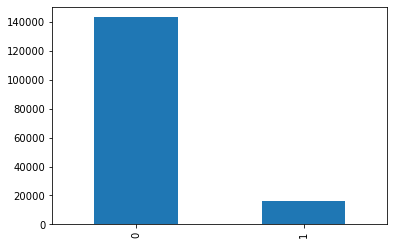

In [5]:
print(data['toxic'].value_counts())

data['toxic'].value_counts().plot(kind='bar')
plt.show()

In [6]:
difference = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]
print(f'Классы разнятся в {difference.round(1)} раз')

Классы разнятся в 8.8 раз


Есть дисбаланс классов, положительных отзывов почти в 9 раз больше чем токсичных/ отрицательных. При обучении модели следует это учесть.

Так как выборка достаточно большая и процесс обработки и лемматизации занимает достаточно большое количество времени, из генеральной совокупности возьмем только 70% данных.

In [7]:
data = data.sample(int(data.shape[0] * 0.7))
print(data['toxic'].value_counts())
difference = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]
print(f'После сокращения данных классы разнятся в {difference.round(1)} раз')

0    100155
1     11349
Name: toxic, dtype: int64
После сокращения данных классы разнятся в 8.8 раз


В тексте присутствуют разные регистры, а также символы и числа. Обработаем данные и уберем все лижние.

In [8]:
data['text'] = data['text'].map(lambda x: x.lower())

In [9]:
#функция для определения POS-тега 
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ
                , 'N': wordnet.NOUN
                , 'V': wordnet.VERB
                , 'R': wordnet.ADV
               }  
    return tag_dict.get(tag, wordnet.NOUN)

def lemmat_text(text):
    text = [lemmat.lemmatize(word, get_wordnet_pos(word)) for word in text]
    return ' '.join(text)

In [10]:
%%time

stop_words = stopwords.words('english')
lemmat = WordNetLemmatizer()

#токенизировал/ разделил строки на отдельные слова
data['text_clean'] = data['text'].map(lambda x: nltk.word_tokenize(x, language = 'english'))
#print(1, data['text_clean'][1])

#проверил и удалил встречающиеся стоп слова
data['text_clean'] = data['text_clean'].map(lambda x: [word for word in x if word not in stop_words])
#print(2, data['text_clean'][1])

#собрал из слов предложение
data['text_clean'] = data['text_clean'].map(lambda x: ' '.join(x))
#print(3, data['text_clean'][1])

#удалил из предложений все лишние знаки
data['text_clean'] = data['text_clean'].map(lambda x: re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', 'ssite', x))
data['text_clean'] = data['text_clean'].map(lambda x: re.sub(r'(@[^s]+)', 'polzovatel', x))
#print(4, data['text_clean'][1])

stop_words.append('ssite')
stop_words.append('polzovatel')

data['text_clean'] = data['text_clean'].map(lambda x: re.sub(r'[^a-z]', ' ', x))
#print(5, data['text_clean'][1])

#снова токенизировал/ разделил строки на отдельные слова
data['text_clean'] = data['text_clean'].map(lambda x: nltk.word_tokenize(x, language = 'english'))
#print(6, data['text_clean'][1])

#проверил и удалили встречающиеся стоп слова
data['text_clean'] = data['text_clean'].map(lambda x: [word for word in x if word not in stop_words])                                      
#print(7, data['text_clean'][1])

#data['text_clean'] = data['text_clean'].apply(lemmat_text)print(8, data['text_clean'][1])

#лематтизировал слова, привел к начальной форме и собрал из слов предложение
data['text_clean'] = data['text_clean'].apply(lemmat_text)
#print(8, data['text_clean'][1])

CPU times: total: 33min 22s
Wall time: 34min 26s


## Обучение

Выделим отдельно целевой и общий признак.

In [11]:
X = data['text_clean']
y = data['toxic']

Разделим наш датасет на обучающую и тестовую выборки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=RANDOM_STATE, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(89203,)
(22301,)
(89203,)
(22301,)


In [13]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

X_train = count_tf_idf.fit_transform(X_train)
X_test = count_tf_idf.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(89203, 105072)
(22301, 105072)


In [14]:
#напишем функцию для моделей с учетом дисбаланса классов
def cv_model(model, params, X, y):
    best_model = GridSearchCV(estimator = model
                              , param_grid = params
                              , scoring = 'f1'
                              #, n_jobs=-1
                              , cv = 5
                              , verbose = 5
                             )
    return best_model.fit(X, y)

### Обучим модель LogisticRegression

In [15]:
#%%time

#pipe_lr = Pipeline([('clf', LogisticRegression())])

#grid_params_lr = [{'clf__random_state': [RANDOM_STATE]
#                , 'clf__solver': ['lbfgs', 'liblinear']
#                , 'clf__max_iter': [500]
#                , 'clf__penalty': ['l2', 'l1']
#                , 'clf__class_weight': ['balanced']
#               }]

#best_model_lr = cv_model(pipe_lr
#                         , grid_params_lr 
#                         , X_train
#                         , y_train)
#print(f'Лучшие параметры модели LogisticRegression: {best_model_lr.best_params_}')
#print(f'Лучший показатель RMSE для LogisticRegression: {best_model_lr.best_score_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__random_state=12345, clf__solver=lbfgs;, score=0.747 total time=   2.1s
[CV 2/5] END clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__random_state=12345, clf__solver=lbfgs;, score=0.742 total time=   2.9s
[CV 3/5] END clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__random_state=12345, clf__solver=lbfgs;, score=0.733 total time=   1.8s
[CV 4/5] END clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__random_state=12345, clf__solver=lbfgs;, score=0.742 total time=   2.6s
[CV 5/5] END clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__random_state=12345, clf__solver=lbfgs;, score=0.743 total time=   1.5s
[CV 1/5] END clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__random_state=12345, clf__solver=liblinear;, score=0.747 total time=   0.6s
[CV 2/5] END clf__

C:\Users\TFL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\TFL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\TFL\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\TFL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

Лучшие параметры модели LogisticRegression: {'clf__class_weight': 'balanced', 'clf__max_iter': 500, 'clf__penalty': 'l2', 'clf__random_state': 12345, 'clf__solver': 'lbfgs'}
Лучший показатель RMSE для LogisticRegression: 0.7413023785904349
Wall time: 21 s


In [15]:
%%time

parametrs_lr = {'random_state': [RANDOM_STATE]
                , 'solver': ['lbfgs', 'liblinear']
                , 'max_iter': [700]
                , 'penalty': ['l2', 'l1']
                , 'class_weight': ['balanced']
               }

best_model_lr = cv_model(LogisticRegression()
                    , parametrs_lr 
                    , X_train
                    , y_train)
print(f'Лучшие параметры модели LogisticRegression: {best_model_lr.best_params_}')
print(f'Лучший показатель RMSE для LogisticRegression: {best_model_lr.best_score_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END class_weight=balanced, max_iter=700, penalty=l2, random_state=12345, solver=lbfgs;, score=0.740 total time=   1.8s
[CV 2/5] END class_weight=balanced, max_iter=700, penalty=l2, random_state=12345, solver=lbfgs;, score=0.754 total time=   1.6s
[CV 3/5] END class_weight=balanced, max_iter=700, penalty=l2, random_state=12345, solver=lbfgs;, score=0.748 total time=   2.3s
[CV 4/5] END class_weight=balanced, max_iter=700, penalty=l2, random_state=12345, solver=lbfgs;, score=0.745 total time=   1.4s
[CV 5/5] END class_weight=balanced, max_iter=700, penalty=l2, random_state=12345, solver=lbfgs;, score=0.736 total time=   2.0s
[CV 1/5] END class_weight=balanced, max_iter=700, penalty=l2, random_state=12345, solver=liblinear;, score=0.740 total time=   0.6s
[CV 2/5] END class_weight=balanced, max_iter=700, penalty=l2, random_state=12345, solver=liblinear;, score=0.754 total time=   0.8s
[CV 3/5] END class_weight=balanced, 

C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END class_weight=balanced, max_iter=700, penalty=l1, random_state=12345, solver=liblinear;, score=0.737 total time=47.6min
[CV 2/5] END class_weight=balanced, max_iter=700, penalty=l1, random_state=12345, solver=liblinear;, score=0.753 total time=   0.7s
[CV 3/5] END class_weight=balanced, max_iter=700, penalty=l1, random_state=12345, solver=liblinear;, score=0.744 total time=   0.9s
[CV 4/5] END class_weight=balanced, max_iter=700, penalty=l1, random_state=12345, solver=liblinear;, score=0.746 total time=   0.8s
[CV 5/5] END class_weight=balanced, max_iter=700, penalty=l1, random_state=12345, solver=liblinear;, score=0.738 total time=   0.7s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\79174\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueE

Лучшие параметры модели LogisticRegression: {'class_weight': 'balanced', 'max_iter': 700, 'penalty': 'l2', 'random_state': 12345, 'solver': 'liblinear'}
Лучший показатель RMSE для LogisticRegression: 0.7447868041321499
CPU times: total: 48min 24s
Wall time: 47min 53s


### Обучим модель SGDClassifier

In [16]:
%%time

parametrs_sgdc = {'random_state': [RANDOM_STATE]
                  , 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
                  , 'max_iter': [700]
                  , 'penalty': ['l2', 'l1', 'elasticnet']
                  , 'class_weight': ['balanced']}
best_model_sgdc = cv_model(SGDClassifier()
                          , parametrs_sgdc
                          , X_train
                          , y_train)

print(f'Лучшие параметры модели SGDClassifier: {best_model_sgdc.best_params_}')
print(f'Лучший показатель RMSE для SGDClassifier: {best_model_sgdc.best_score_}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.721 total time=   0.2s
[CV 2/5] END class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.742 total time=   0.2s
[CV 3/5] END class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.735 total time=   0.2s
[CV 4/5] END class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.744 total time=   0.2s
[CV 5/5] END class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.729 total time=   0.1s
[CV 1/5] END class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=0.712 total time=   0.7s
[CV 2/5] END class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=0.717 total time=   0.9s
[CV 3/5] END class_weight=balanced, loss=hinge, max_iter=

C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.691 total time=  10.7s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.710 total time=  11.2s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.701 total time=  10.9s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.691 total time=   9.9s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.690 total time=  11.0s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l1, random_state=12345;, score=0.722 total time=  21.6s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l1, random_state=12345;, score=0.700 total time=  21.5s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l1, random_state=12345;, score=0.704 total time=  22.4s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l1, random_state=12345;, score=0.696 total time=  22.2s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l1, random_state=12345;, score=0.709 total time=  21.4s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=elasticnet, random_state=12345;, score=0.700 total time=  21.9s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=elasticnet, random_state=12345;, score=0.710 total time=  21.9s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=elasticnet, random_state=12345;, score=0.707 total time=  22.5s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=elasticnet, random_state=12345;, score=0.699 total time=  22.2s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=elasticnet, random_state=12345;, score=0.694 total time=  21.6s
[CV 1/5] END class_weight=balanced, loss=perceptron, max_iter=700, penalty=l2, random_state=12345;, score=0.710 total time=   0.1s
[CV 2/5] END class_weight=balanced, loss=perceptron, max_iter=700, penalty=l2, random_state=12345;, score=0.706 total time=   0.1s
[CV 3/5] END class_weight=balanced, loss=perceptron, max_iter=700, penalty=l2, random_state=12345;, score=0.705 total time=   0.1s
[CV 4/5] END class_weight=balanced, loss=perceptron, max_iter=700, penalty=l2, random_state=12345;, score=0.708 total time=   0.1s
[CV 5/5] END class_weight=balanced, loss=perceptron, max_iter=700, penalty=l2, random_state=12345;, score=0.701 total time=   0.1s
[CV 1/5] END class_weight=balanced, loss=perceptron, max_iter=700, penalty=l1, random_state=12345;, score=0.615 total time=   0.4s
[CV 2/5] END class_weight=balanced, loss=perceptron, max_iter=700, penal

### Обучим модель LinearSVC

In [25]:
%%time

parametrs_lsvc = {'random_state': [RANDOM_STATE]
                  , 'loss': ['hinge', 'squared_hinge']
                  , 'C': [0.2, 0.3, 0.4, 0.5]
                  , 'max_iter': [700]
                  , 'penalty': ['l2', 'l1']
                  , 'class_weight': ['balanced']}
best_model_lsvc = cv_model(LinearSVC()
                          , parametrs_lsvc
                          , X_train
                          , y_train)

print(f'Лучшие параметры модели LinearSVC: {best_model_lsvc.best_params_}')
print(f'Лучший показатель RMSE для LinearSVC: {best_model_lsvc.best_score_}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=0.2, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.723 total time=   0.6s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=0.2, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.746 total time=   0.6s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=0.2, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.740 total time=   0.6s
[CV 4/5] END C=0.2, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.744 total time=   0.6s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=0.2, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.732 total time=   0.6s
[CV 1/5] END C=0.2, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 2/5] END C=0.2, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 3/5] END C=0.2, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 4/5] END C=0.2, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 5/5] END C=0.2, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 1/5] END C=0.2, class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.746 total time=   0.6s
[CV 2/5] END C=0.2, class_weight=balanced, loss=squared_hinge, max_iter

C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=0.3, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.732 total time=   0.9s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=0.3, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.748 total time=   0.8s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=0.3, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.741 total time=   0.8s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=0.3, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.746 total time=   0.8s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=0.3, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.736 total time=   0.7s
[CV 1/5] END C=0.3, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 2/5] END C=0.3, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 3/5] END C=0.3, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 4/5] END C=0.3, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 5/5] END C=0.3, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 1/5] END C=0.3, class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.749 total time=   0.6s
[CV 2/5] END C=0.3, class_weight=balanced, loss=squared_hinge, max_iter

C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=0.4, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.737 total time=   1.3s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=0.4, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.749 total time=   1.2s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=0.4, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.745 total time=   1.3s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=0.4, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.747 total time=   1.2s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=0.4, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.734 total time=   1.1s
[CV 1/5] END C=0.4, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 2/5] END C=0.4, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 3/5] END C=0.4, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 4/5] END C=0.4, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 5/5] END C=0.4, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 1/5] END C=0.4, class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.751 total time=   0.9s
[CV 2/5] END C=0.4, class_weight=balanced, loss=squared_hinge, max_iter

C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=0.5, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.752 total time=   1.5s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=0.5, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.747 total time=   1.1s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=0.5, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.747 total time=   1.3s


C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=0.5, class_weight=balanced, loss=hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.736 total time=   1.3s
[CV 1/5] END C=0.5, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 2/5] END C=0.5, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 3/5] END C=0.5, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 5/5] END C=0.5, class_weight=balanced, loss=hinge, max_iter=700, penalty=l1, random_state=12345;, score=nan total time=   0.0s
[CV 1/5] END C=0.5, class_weight=balanced, loss=squared_hinge, max_iter=700, penalty=l2, random_state=12345;, score=0.753 total time=   1.0s
[CV 2/5] END C=0.5, class_weight=balanced, loss=squared_hinge, max_iter

C:\Users\79174\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\79174\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\79174\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(mult

Лучшие параметры модели LinearSVC: {'C': 0.5, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 700, 'penalty': 'l2', 'random_state': 12345}
Лучший показатель RMSE для LinearSVC: 0.7558133067868076
CPU times: total: 40.5 s
Wall time: 41.7 s


### Обучим модель DecisionTreeClassifier

In [18]:
%%time

parametrs_dtc = {'random_state': [RANDOM_STATE]
                 , 'class_weight': ['balanced']
                 , 'max_depth': range(100, 251, 25)
                }
best_model_dtc = cv_model(DecisionTreeClassifier()
                          , parametrs_dtc
                          , X_train
                          , y_train)

print(f'Лучшие параметры модели DecisionTreeClassifier: {best_model_dtc.best_params_}')
print(f'Лучший показатель RMSE для DecisionTreeClassifier: {best_model_dtc.best_score_}')

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END class_weight=balanced, max_depth=100, random_state=12345;, score=0.641 total time=  36.5s
[CV 2/5] END class_weight=balanced, max_depth=100, random_state=12345;, score=0.644 total time=  37.3s
[CV 3/5] END class_weight=balanced, max_depth=100, random_state=12345;, score=0.635 total time=  38.5s
[CV 4/5] END class_weight=balanced, max_depth=100, random_state=12345;, score=0.646 total time=  39.4s
[CV 5/5] END class_weight=balanced, max_depth=100, random_state=12345;, score=0.644 total time=  38.6s
[CV 1/5] END class_weight=balanced, max_depth=125, random_state=12345;, score=0.651 total time=  36.3s
[CV 2/5] END class_weight=balanced, max_depth=125, random_state=12345;, score=0.648 total time=  38.8s
[CV 3/5] END class_weight=balanced, max_depth=125, random_state=12345;, score=0.646 total time=  42.7s
[CV 4/5] END class_weight=balanced, max_depth=125, random_state=12345;, score=0.650 total time=  46.4s
[CV 5/5] END 

### Обучим модель RandomForestClassifier

In [19]:
%%time

parametrs_rfc = {'random_state': [RANDOM_STATE]
                 , 'class_weight': ['balanced']
                 , 'n_estimators': [10]
                 , 'max_depth': [175, 200, 225, 250]
                }

best_model_rfc = cv_model(RandomForestClassifier()
                          , parametrs_rfc
                          , X_train
                          , y_train)

print(f'Лучшие параметры модели RandomForestClassifier: {best_model_rfc.best_params_}')
print(f'Лучший показатель RMSE для RandomForestClassifier: {best_model_rfc.best_score_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END class_weight=balanced, max_depth=175, n_estimators=10, random_state=12345;, score=0.565 total time=  29.4s
[CV 2/5] END class_weight=balanced, max_depth=175, n_estimators=10, random_state=12345;, score=0.566 total time=  30.1s
[CV 3/5] END class_weight=balanced, max_depth=175, n_estimators=10, random_state=12345;, score=0.525 total time=  30.3s
[CV 4/5] END class_weight=balanced, max_depth=175, n_estimators=10, random_state=12345;, score=0.536 total time=  30.2s
[CV 5/5] END class_weight=balanced, max_depth=175, n_estimators=10, random_state=12345;, score=0.542 total time=  30.2s
[CV 1/5] END class_weight=balanced, max_depth=200, n_estimators=10, random_state=12345;, score=0.575 total time=  32.0s
[CV 2/5] END class_weight=balanced, max_depth=200, n_estimators=10, random_state=12345;, score=0.577 total time=  32.3s
[CV 3/5] END class_weight=balanced, max_depth=200, n_estimators=10, random_state=12345;, score=0.546

### Обучим модель LGBMClassifier

In [20]:
%%time

parametrs_lgbmc = {'random_state': [RANDOM_STATE]
                   , 'class_weight': ['balanced']
                   , 'n_estimators': range(100, 251, 50)
                   , 'max_depth': range(10, 50, 5)}

best_model_lgbmc = cv_model(LGBMClassifier()
                            , parametrs_lgbmc
                            , X_train
                            , y_train)

print(f'Лучшие параметры модели LightGBMRegressor: {best_model_lgbmc.best_params_}')
print(f'Лучший показатель RMSE для LightGBMRegressor: {best_model_lgbmc.best_score_}')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END class_weight=balanced, max_depth=10, n_estimators=100, random_state=12345;, score=0.723 total time=   8.3s
[CV 2/5] END class_weight=balanced, max_depth=10, n_estimators=100, random_state=12345;, score=0.729 total time=   8.1s
[CV 3/5] END class_weight=balanced, max_depth=10, n_estimators=100, random_state=12345;, score=0.726 total time=   8.8s
[CV 4/5] END class_weight=balanced, max_depth=10, n_estimators=100, random_state=12345;, score=0.740 total time=   8.6s
[CV 5/5] END class_weight=balanced, max_depth=10, n_estimators=100, random_state=12345;, score=0.737 total time=   8.2s
[CV 1/5] END class_weight=balanced, max_depth=10, n_estimators=150, random_state=12345;, score=0.733 total time=  11.2s
[CV 2/5] END class_weight=balanced, max_depth=10, n_estimators=150, random_state=12345;, score=0.742 total time=  10.7s
[CV 3/5] END class_weight=balanced, max_depth=10, n_estimators=150, random_state=12345;, score=0.7

### Обучим модель CatBoostClassifier

In [21]:
%%time

parametrs_cbc = {'random_state': [RANDOM_STATE]
                   , 'auto_class_weights': ['Balanced']
                   , 'iterations': [500]
                }

best_model_cbc = cv_model(CatBoostClassifier()
                          , parametrs_cbc
                          , X_train
                          , y_train)

print(f'Лучшие параметры модели CatBoostClassifier: {best_model_cbc.best_params_}')
print(f'Лучший показатель RMSE для CatBoostClassifier: {best_model_cbc.best_score_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.12034
0:	learn: 0.6428587	total: 1.39s	remaining: 11m 32s
1:	learn: 0.6067874	total: 2.45s	remaining: 10m 9s
2:	learn: 0.5806789	total: 3.29s	remaining: 9m 5s
3:	learn: 0.5619470	total: 4.15s	remaining: 8m 34s
4:	learn: 0.5498864	total: 5.13s	remaining: 8m 28s
5:	learn: 0.5396614	total: 6s	remaining: 8m 13s
6:	learn: 0.5310166	total: 6.84s	remaining: 8m 1s
7:	learn: 0.5206713	total: 7.68s	remaining: 7m 52s
8:	learn: 0.5138065	total: 8.59s	remaining: 7m 48s
9:	learn: 0.5075563	total: 9.66s	remaining: 7m 53s
10:	learn: 0.5021367	total: 10.6s	remaining: 7m 49s
11:	learn: 0.4971553	total: 11.5s	remaining: 7m 47s
12:	learn: 0.4930247	total: 12.4s	remaining: 7m 44s
13:	learn: 0.4883778	total: 13.3s	remaining: 7m 40s
14:	learn: 0.4841099	total: 14.1s	remaining: 7m 35s
15:	learn: 0.4805429	total: 15s	remaining: 7m 34s
16:	learn: 0.4766485	total: 15.9s	remaining: 7m 30s
17:	learn: 0.4722222	total: 16.7s	remaining:

### Сведем полученные показатели по моделям в одну таблицу и выведем

In [27]:
model = ['LogisticRegression'
         , 'SGDClassifier'
         , 'LinearSVC'
         , 'DecisionTreeClassifier'
         , 'RandomForestClassifier'
         , 'LightGBMClassifier'
         , 'CatBoostClassifier']

params = [best_model_lr.best_params_
          , best_model_sgdc.best_params_
          , best_model_lsvc.best_params_
          , best_model_dtc.best_params_
          , best_model_rfc.best_params_
          , best_model_lgbmc.best_params_
          , best_model_cbc.best_params_]

f1_score_train = [best_model_lr.best_score_
                  , best_model_sgdc.best_score_
                  , best_model_lsvc.best_score_
                  , best_model_dtc.best_score_
                  , best_model_rfc.best_score_
                  , best_model_lgbmc.best_score_
                  , best_model_cbc.best_score_]

result = {'Model': model, 'Hyperparameters': params, 'F1 score in training': f1_score_train}

display(pd.DataFrame(result))

,Model,Hyperparameters,F1 score in training
0,LogisticRegression,"{'class_weight': 'balanced', 'max_iter': 700, 'penalty': 'l2', 'random_state': 12345, 'solver': 'liblinear'}",0.744787
1,SGDClassifier,"{'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 700, 'penalty': 'l2', 'random_state': 12345}",0.748787
2,LinearSVC,"{'C': 0.5, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 700, 'penalty': 'l2', 'random_state': 12345}",0.755813
3,DecisionTreeClassifier,"{'class_weight': 'balanced', 'max_depth': 200, 'random_state': 12345}",0.651080
4,RandomForestClassifier,"{'class_weight': 'balanced', 'max_depth': 200, 'n_estimators': 10, 'random_state': 12345}",0.564845
5,LightGBMClassifier,"{'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 250, 'random_state': 12345}",0.751451
6,CatBoostClassifier,"{'auto_class_weights': 'Balanced', 'iterations': 500, 'random_state': 12345}",0.747158


Из всех рассмотренных моделей самыми лучшими оказались модели LinearSVC с параметрами {'C': 0.5, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 700, 'penalty': 'l2', 'random_state': 12345} и LightGBMClassifier с параметрами {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 250, 'random_state': 12345} и показателем f1_score равным 0,756 и 0,751 соответственно.

Проведем предсказание по модели LinearSVC на тестовой выборке.

### Тестирование

In [28]:
%%time

model_test = LinearSVC(C = 0.5
                       , class_weight = 'balanced'
                       , loss = 'squared_hinge'
                       , max_iter = 700
                       , penalty = 'l2'
                       , random_state = RANDOM_STATE)
model_test.fit(X_train, y_train)
predictions_test = model_test.predict(X_test)
print(f'Показатель метрики f1_score на тестовой выборке по лучшей модели составляет: {f1_score(y_test, predictions_test).round(3)}')

Показатель метрики f1_score на тестовой выборке по лучшей модели составляет: 0.751
CPU times: total: 1.3 s
Wall time: 1.34 s


## Выводы

Открыли и ознакомились с данными.

Для решения данной задачи NLP нужен только текст, для этого обработали данные, привели тексты к нижнему регистру, произвели очистку данных от всех возможных знаков и символов, удалили стоп-слова.

Обучили разные модели и подобрали оптимальны параметры модели. 

Произвели предсказание на тестовой выборке. 

Из всех рассмотренных моделей самыми лучшими оказались модели LinearSVC с параметрами {'C': 0.5, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 700, 'penalty': 'l2', 'random_state': 12345} и показателем f1_score равным 0,756. Чуть хуже себя показала модель LightGBMClassifier с параметрами {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 250, 'random_state': 12345} и показателем f1_score равным 0,751.

Из всех рассмотренных моделей была выбрана модель LinearSVC и на тестовой выборке показатель F1 score составляет 0.751.